In [1]:
import sys
sys.path.append('..')

In [2]:
from spinesTS.preprocessing import split_series
from spinesTS.plotting import plot2d
from sklearn.metrics import r2_score

In [3]:
from spinesTS.data import BuiltInSeriesData
from spinesTS.nn import *
from spinesTS.metrics import mean_absolute_error
from spinesTS.metrics import mean_absolute_percentage_error

In [4]:
series_data = BuiltInSeriesData()

+----+----------------------+----------------------------------------------------------------------+
|    | ds name              | columns                                                              |
+----+----------------------+----------------------------------------------------------------------+
|  0 | AirPassengers        | Month, #Passengers                                                   |
|  1 | ETTh1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  2 | ETTh2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  3 | ETTm1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  4 | ETTm2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  5 | Electric_Production  | date, value                                                          |
|  6 | M3_monthly_FTS       | series_id, method_id, forecast, horizon, timestamp, origin_ti

In [5]:
cs = series_data['Web_Sales']

x_train, x_test, y_train, y_test = split_series(cs['type_a'], cs['type_a'], 128, 24, train_size=0.9)

In [6]:
x_train.shape, x_test.shape

((1744, 128), (194, 128))

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

scaler2 = MinMaxScaler()
y_train = scaler2.fit_transform(y_train)
y_test = scaler2.transform(y_test)

# StackingRNN

In [ ]:
model = StackingRNN(128, 24, random_seed=42, loss_fn='mae', learning_rate=0.001, dropout=0.1, diff_n=0, 
                    stack_num=10, num_layers=1, bidirectional=True, device='cpu')
model.fit(x_train, y_train, eval_set=(x_test, y_test), batch_size=32,
             min_delta=0, patience=100, epochs=3000, verbose=True, lr_scheduler=None)
y_pred_inverse = scaler2.inverse_transform(model.predict(x_test))

y_test_inverse = scaler2.inverse_transform(y_test)

print(f"r2: {r2_score(y_test_inverse.T, y_pred_inverse.T)}")
print(f"mae: {mean_absolute_error(y_test_inverse, y_pred_inverse)}")
print(f"mape: {mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)}")
a = plot2d(y_test_inverse, y_pred_inverse, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))

Using cpu backend
Epoch 1/3000  
55/55 - p0 - loss: 0.1338 - mae: 0.1294 - val_loss: 0.1467 - val_mae: 0.1467 - 2.88s/epoch - 0.052s/step
Epoch 2/3000  
55/55 - p0 - loss: 0.0791 - mae: 0.1249 - val_loss: 0.0422 - val_mae: 0.0422 - 2.75s/epoch - 0.050s/step
Epoch 3/3000  
55/55 - p1 - loss: 0.0463 - mae: 0.1385 - val_loss: 0.0590 - val_mae: 0.0590 - 2.72s/epoch - 0.049s/step
Epoch 4/3000  
55/55 - p0 - loss: 0.0614 - mae: 0.1291 - val_loss: 0.0394 - val_mae: 0.0394 - 3.42s/epoch - 0.062s/step
Epoch 5/3000  
55/55 - p1 - loss: 0.0581 - mae: 0.1312 - val_loss: 0.0411 - val_mae: 0.0411 - 2.78s/epoch - 0.050s/step
Epoch 6/3000  
55/55 - p2 - loss: 0.0466 - mae: 0.1326 - val_loss: 0.0450 - val_mae: 0.0450 - 110.71s/epoch - 2.013s/step
Epoch 7/3000  
55/55 - p3 - loss: 0.0556 - mae: 0.1271 - val_loss: 0.0609 - val_mae: 0.0609 - 3.27s/epoch - 0.059s/step
Epoch 8/3000  
55/55 - p4 - loss: 0.0460 - mae: 0.1286 - val_loss: 0.0561 - val_mae: 0.0561 - 3.13s/epoch - 0.057s/step
Epoch 9/3000  
55/55

Using cpu backend
Epoch 1/3000  
55/55 - p0 - loss: 0.1209 - mae: 0.1306 - val_loss: 0.1380 - val_mae: 0.1380 - 1.28s/epoch - 0.023s/step
Epoch 2/3000  
55/55 - p0 - loss: 0.0647 - mae: 0.1240 - val_loss: 0.0455 - val_mae: 0.0455 - 1.19s/epoch - 0.022s/step
Epoch 3/3000  
55/55 - p0 - loss: 0.0569 - mae: 0.1354 - val_loss: 0.0418 - val_mae: 0.0418 - 1.20s/epoch - 0.022s/step
Epoch 4/3000  
55/55 - p0 - loss: 0.0555 - mae: 0.1351 - val_loss: 0.0415 - val_mae: 0.0415 - 1.25s/epoch - 0.023s/step
Epoch 5/3000  
55/55 - p1 - loss: 0.0472 - mae: 0.1300 - val_loss: 0.0441 - val_mae: 0.0441 - 1.18s/epoch - 0.021s/step
Epoch 6/3000  
55/55 - p2 - loss: 0.0479 - mae: 0.1285 - val_loss: 0.0484 - val_mae: 0.0484 - 1.20s/epoch - 0.022s/step
Epoch 7/3000  
55/55 - p3 - loss: 0.0485 - mae: 0.1272 - val_loss: 0.0437 - val_mae: 0.0437 - 1.21s/epoch - 0.022s/step
Epoch 8/3000  
55/55 - p4 - loss: 0.0450 - mae: 0.1264 - val_loss: 0.0460 - val_mae: 0.0460 - 1.19s/epoch - 0.022s/step
Epoch 9/3000  
55/55 -

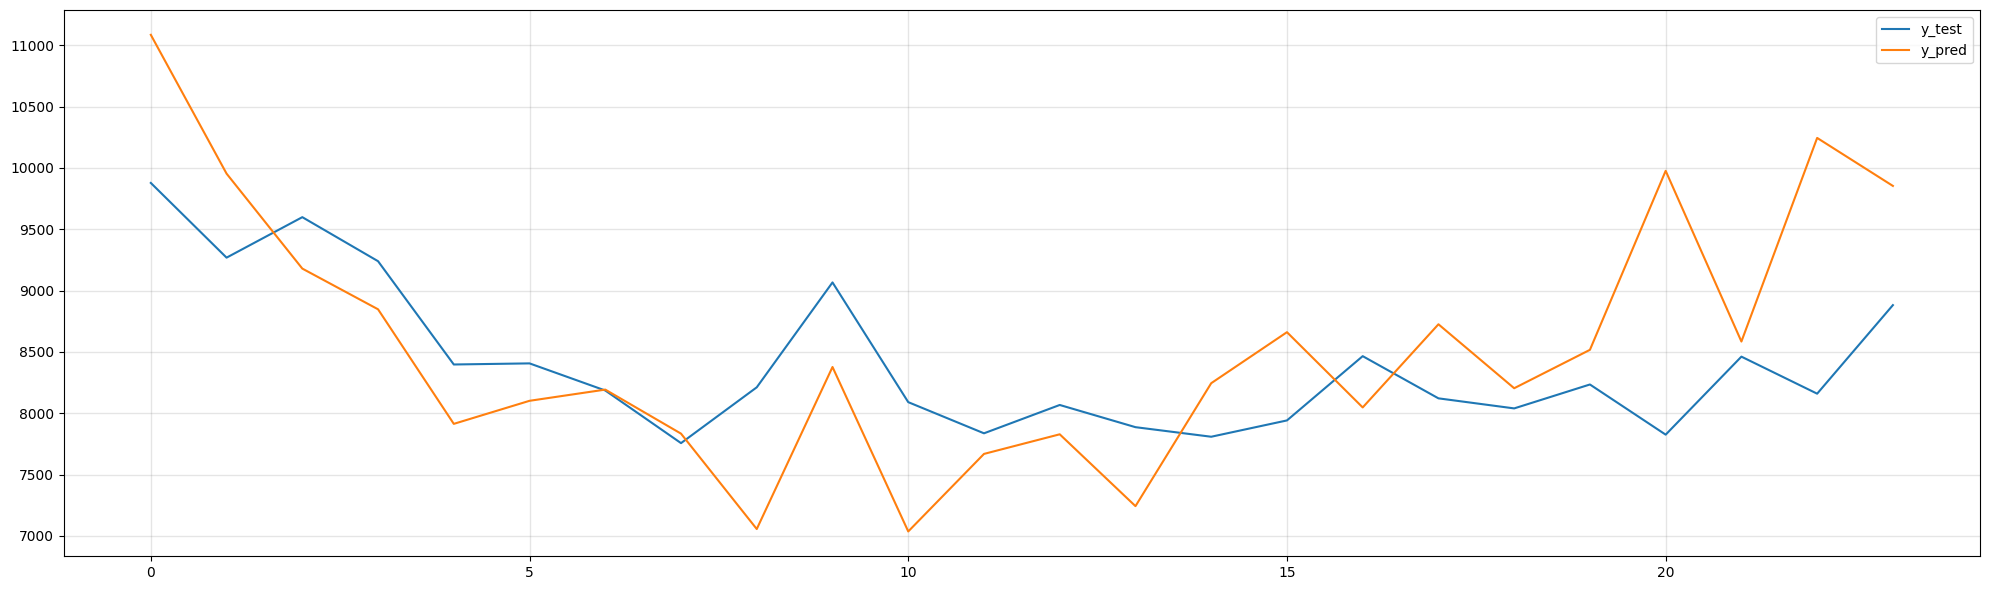

In [13]:
model = StackingRNN(128, 24, random_seed=42, loss_fn='mae', learning_rate=0.001, dropout=0.1, diff_n=0, 
                    stack_num=4, num_layers=1, bidirectional=True, device='cpu')
model.fit(x_train, y_train, eval_set=(x_test, y_test), batch_size=32,
             min_delta=0, patience=100, epochs=3000, verbose=True, lr_scheduler=None)
y_pred_inverse = scaler2.inverse_transform(model.predict(x_test))

y_test_inverse = scaler2.inverse_transform(y_test)

print(f"r2: {r2_score(y_test_inverse.T, y_pred_inverse.T)}")
print(f"mae: {mean_absolute_error(y_test_inverse, y_pred_inverse)}")
print(f"mape: {mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)}")
a = plot2d(y_test_inverse, y_pred_inverse, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))

Using cpu backend
Epoch 1/3000  
55/55 - p0 - loss: 0.0777 - mae: 0.1301 - val_loss: 0.1061 - val_mae: 0.1061 - 2.04s/epoch - 0.037s/step
Epoch 2/3000  
55/55 - p0 - loss: 0.0707 - mae: 0.1295 - val_loss: 0.0419 - val_mae: 0.0419 - 1.77s/epoch - 0.032s/step
Epoch 3/3000  
55/55 - p0 - loss: 0.0669 - mae: 0.1452 - val_loss: 0.0391 - val_mae: 0.0391 - 1.85s/epoch - 0.034s/step
Epoch 4/3000  
55/55 - p1 - loss: 0.0554 - mae: 0.1372 - val_loss: 0.0404 - val_mae: 0.0404 - 1.76s/epoch - 0.032s/step
Epoch 5/3000  
55/55 - p0 - loss: 0.0509 - mae: 0.1296 - val_loss: 0.0383 - val_mae: 0.0383 - 1.74s/epoch - 0.032s/step
Epoch 6/3000  
55/55 - p1 - loss: 0.0559 - mae: 0.1321 - val_loss: 0.0616 - val_mae: 0.0616 - 1.88s/epoch - 0.034s/step
Epoch 7/3000  
55/55 - p2 - loss: 0.0519 - mae: 0.1264 - val_loss: 0.0536 - val_mae: 0.0536 - 1.86s/epoch - 0.034s/step
Epoch 8/3000  
55/55 - p3 - loss: 0.0531 - mae: 0.1261 - val_loss: 0.0500 - val_mae: 0.0500 - 1.84s/epoch - 0.034s/step
Epoch 9/3000  
55/55 -

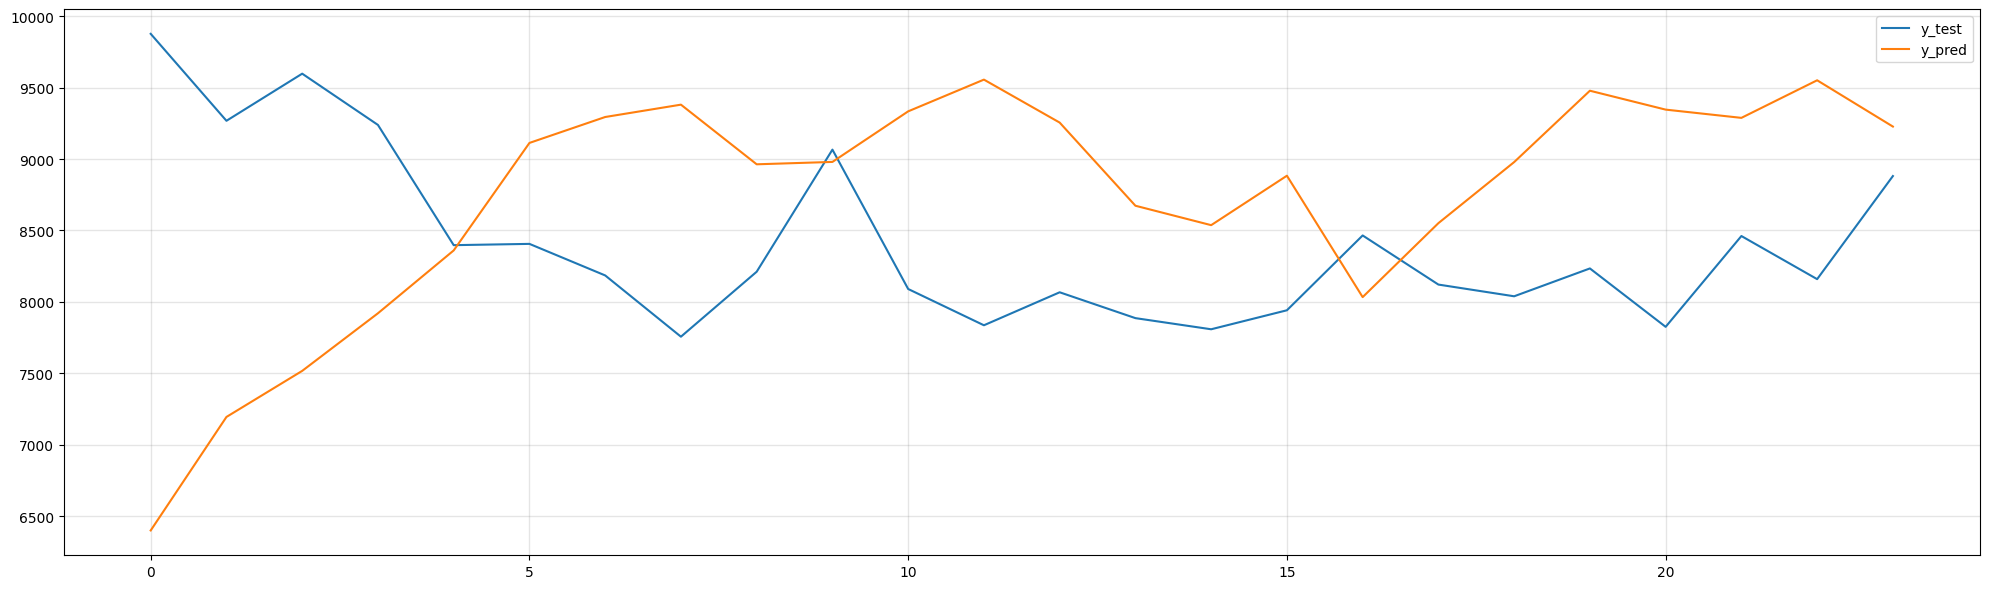

In [14]:
model = StackingRNN(128, 24, random_seed=42, loss_fn='mae', learning_rate=0.001, dropout=0.1, diff_n=0, 
                    stack_num=6, num_layers=1, bidirectional=True, device='cpu')
model.fit(x_train, y_train, eval_set=(x_test, y_test), batch_size=32,
             min_delta=0, patience=100, epochs=3000, verbose=True, lr_scheduler=None)
y_pred_inverse = scaler2.inverse_transform(model.predict(x_test))

y_test_inverse = scaler2.inverse_transform(y_test)

print(f"r2: {r2_score(y_test_inverse.T, y_pred_inverse.T)}")
print(f"mae: {mean_absolute_error(y_test_inverse, y_pred_inverse)}")
print(f"mape: {mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)}")
a = plot2d(y_test_inverse, y_pred_inverse, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))

# GAUNet

Using cpu backend
Epoch 1/3000  
55/55 - p0 - loss: 0.1605 - mae: 0.2696 - val_loss: 0.0907 - val_mae: 0.0907 - 0.26s/epoch - 0.005s/step
Epoch 2/3000  
55/55 - p0 - loss: 0.1435 - mae: 0.1930 - val_loss: 0.0632 - val_mae: 0.0632 - 0.26s/epoch - 0.005s/step
Epoch 3/3000  
55/55 - p0 - loss: 0.1341 - mae: 0.1784 - val_loss: 0.0520 - val_mae: 0.0520 - 0.25s/epoch - 0.005s/step
Epoch 4/3000  
55/55 - p1 - loss: 0.1286 - mae: 0.1698 - val_loss: 0.0544 - val_mae: 0.0544 - 0.26s/epoch - 0.005s/step
Epoch 5/3000  
55/55 - p2 - loss: 0.1215 - mae: 0.1621 - val_loss: 0.0525 - val_mae: 0.0525 - 0.25s/epoch - 0.005s/step
Epoch 6/3000  
55/55 - p0 - loss: 0.1108 - mae: 0.1557 - val_loss: 0.0503 - val_mae: 0.0503 - 0.26s/epoch - 0.005s/step
Epoch 7/3000  
55/55 - p1 - loss: 0.1112 - mae: 0.1520 - val_loss: 0.0511 - val_mae: 0.0511 - 0.25s/epoch - 0.004s/step
Epoch 8/3000  
55/55 - p0 - loss: 0.1032 - mae: 0.1501 - val_loss: 0.0493 - val_mae: 0.0493 - 0.24s/epoch - 0.004s/step
Epoch 9/3000  
55/55 -

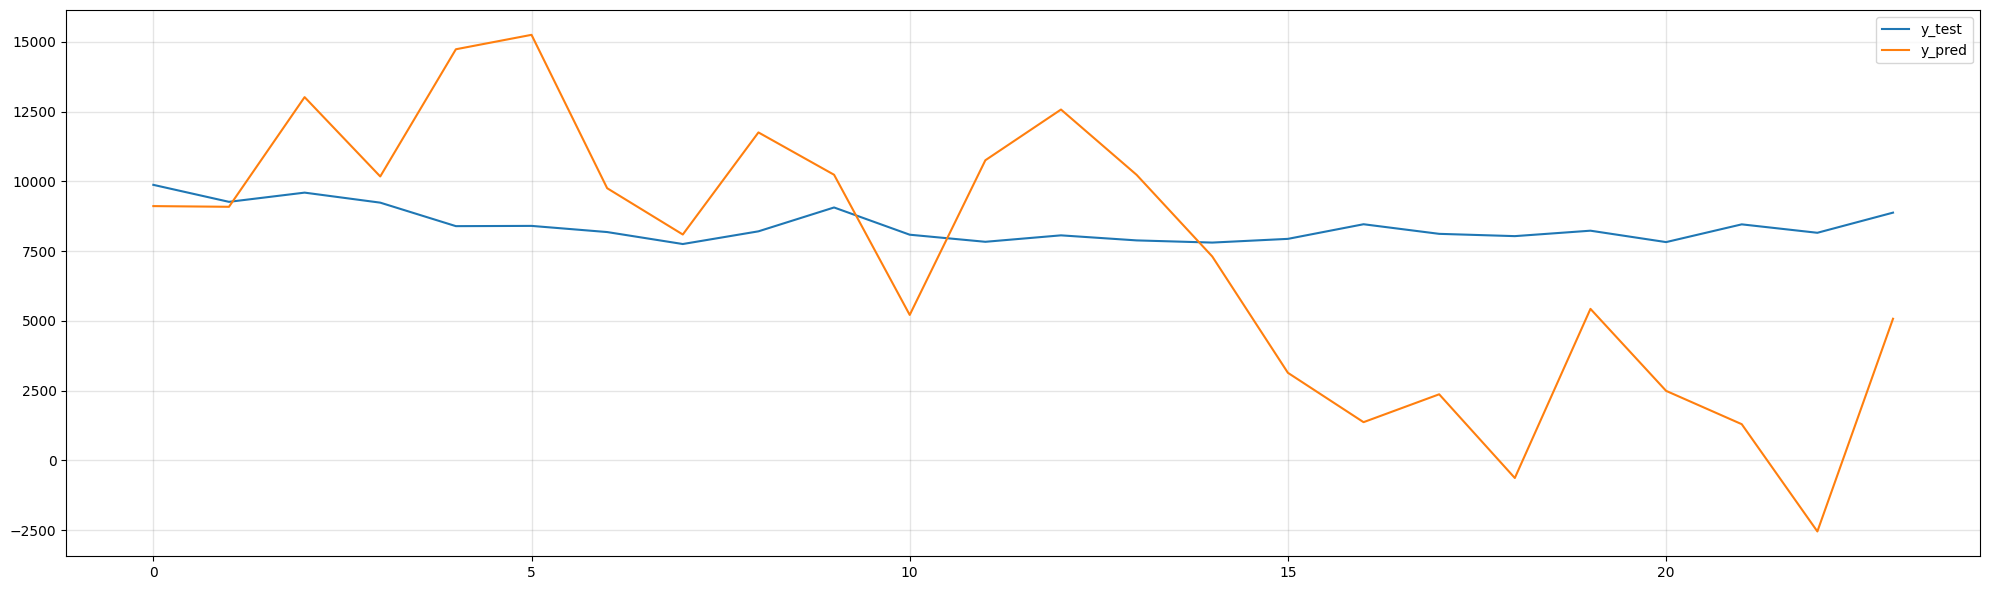

In [9]:
model = GAUNet(128, 24, random_seed=42, flip_features=False, learning_rate=0.001, level=2, device='cpu')
model.fit(x_train, y_train, eval_set=(x_test, y_test), batch_size=32,
             min_delta=0, patience=100, epochs=3000, verbose=True, lr_scheduler=None)
y_pred_inverse = scaler2.inverse_transform(model.predict(x_test))
y_test_inverse = scaler2.inverse_transform(y_test)

print(f"r2: {r2_score(y_test_inverse.T, y_pred_inverse.T)}")
print(f"mae: {mean_absolute_error(y_test_inverse, y_pred_inverse)}")
print(f"mape: {mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)}")
a = plot2d(y_test_inverse, y_pred_inverse, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))

# Time2VecNet

r2: 0.8372770385948494
mae: 2.786961499898275
mape: 0.02698903244076549


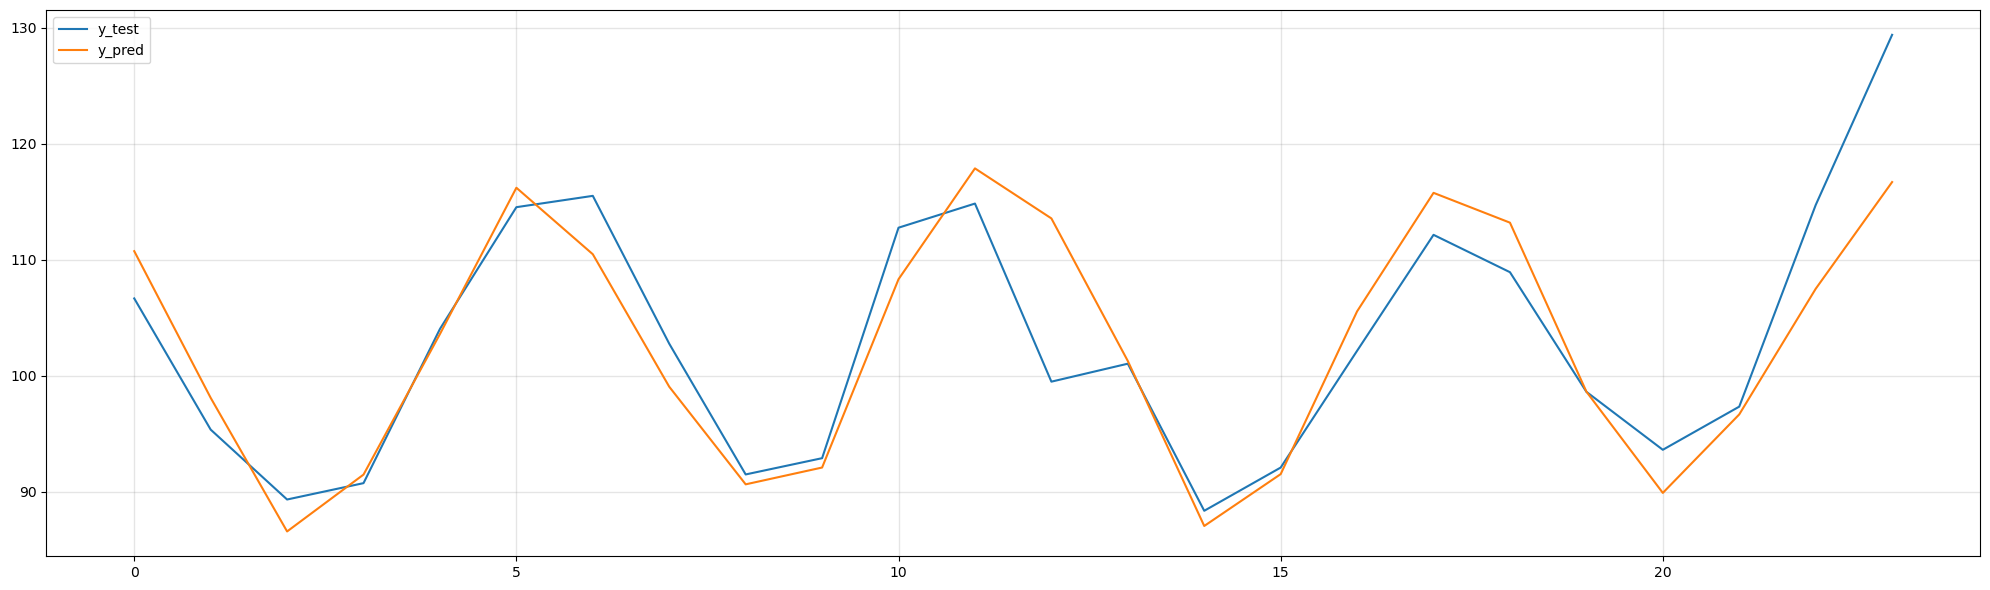

In [9]:
model = Time2VecNet(128, 24, random_seed=42, flip_features=False, learning_rate=0.001, device='cpu')
model.fit(x_train, y_train, eval_set=(x_test, y_test), batch_size=32,
             min_delta=0, patience=100, epochs=3000, verbose=False, lr_scheduler='ReduceLROnPlateau')

y_pred_inverse = model.predict(x_test)

print(f"r2: {r2_score(y_test.T, y_pred_inverse.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred_inverse)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred_inverse)}")
a = plot2d(y_test, y_pred_inverse, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))